Feature Extraction

In [1]:
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import dataloader
import matplotlib.pyplot as plt
import numpy as np

/home/ha/anaconda3/envs/self/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/ha/anaconda3/envs/self/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
data_path ='./catanddog/train'

transform = transforms.Compose([
    transforms.Resize([256,256]),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform = transform
)

train_loader = torch.utils.data.DataLoader(
                train_dataset,
                batch_size=32,
                num_workers=8,
                shuffle=True
)
print(len(train_dataset))

385


In [3]:
train_iter = iter(train_loader)
samples, labels = next(train_iter)

In [4]:
samples[0].size()

torch.Size([3, 224, 224])

In [5]:
labels[1].item()

1

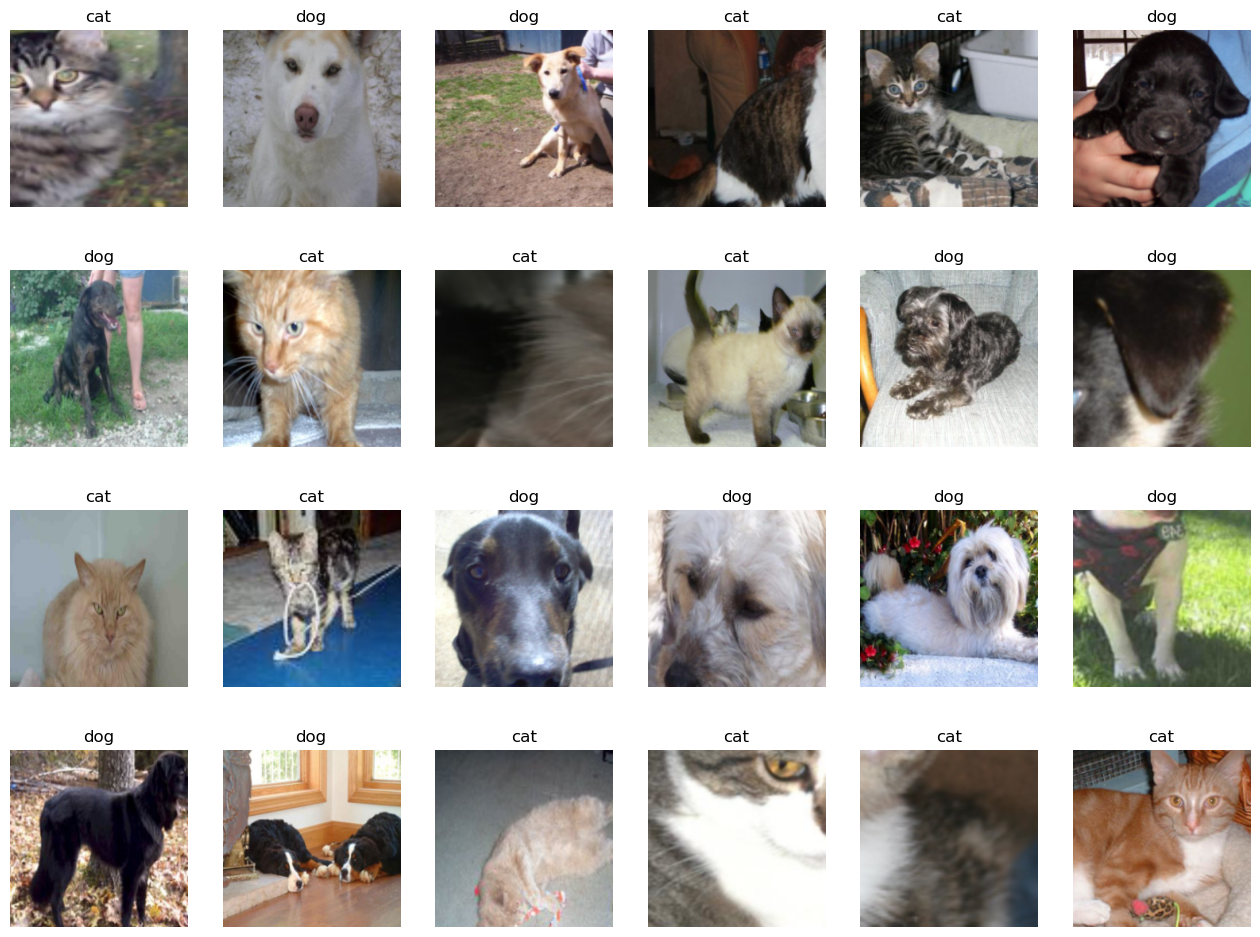

In [6]:
classes = {0:'cat',1:'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()]) #only one element tensors can be converted to Python scalars using x.item()
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(),(1,2,0)))
plt.subplots_adjust(bottom=0.2,top=0.6,hspace=0)

Testing

In [7]:
resnet18 = models.resnet18(pretrained = True)

/home/ha/anaconda3/envs/self/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ha/anaconda3/envs/self/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
set_parameter_requires_grad(resnet18)

In [9]:
resnet18.fc= nn.Linear(512,2)

In [10]:
for name, param in resnet18.named_parameters(): # named_parameters()는 (name, parameter) 조합의 tuple iterator를 준다.
    if param.requires_grad:
        print(name,param.data)

fc.weight tensor([[-0.0125,  0.0433, -0.0138,  ..., -0.0300,  0.0205, -0.0273],
        [ 0.0432,  0.0094,  0.0086,  ...,  0.0291,  0.0227, -0.0043]])
fc.bias tensor([0.0130, 0.0102])


Modeling

In [11]:
model = models.resnet18(pretrained = True)
for param in model.parameters():
    param.requires_grad = False
model.fc= nn.Linear(512,2)
for param in model.fc.parameters():
    param.requires_grad=True
# 보통은 optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [64]:
def train(model, dataloader, criterion, optimizer, device, num_epochs=100,is_train=True):
    since = time.time()
    acc_history = []
    loss_history = []
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch,num_epochs-1))
        print('-'*10)

        running_loss = 0.0
        running_corrects = 0

        for inputs,labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs,labels)
            _, preds = torch.max(outputs,1) # 튜플 형태의 return (values=tensor,indices=tensor)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)

        print('Loss: {:.4f} ACC: {:.4f}'.format(epoch_loss,epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc
        
        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(),os.path.join('./chap05/model/catanddog','{0:0=2d}.pth'.format(epoch)))
        print()
        
    time_eplased = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_eplased // 60, time_eplased % 60))
    print('Best Acc :{:4f}'.format(best_acc))
    return acc_history, loss_history


In [65]:
params_to_update = []
for name, param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print('\t',name)
optimizer = optim.Adam(params_to_update)

	 fc.weight
	 fc.bias


In [66]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
train_acc_hist,train_loss_hist = train(resnet18,train_loader,criterion,optimizer,device)

Epoch 0/99
----------
Loss: 0.1336 ACC: 0.9429

Epoch 1/99
----------
Loss: 0.1095 ACC: 0.9636

Epoch 2/99
----------
Loss: 0.1212 ACC: 0.9481

Epoch 3/99
----------
Loss: 0.1323 ACC: 0.9455

Epoch 4/99
----------
Loss: 0.1194 ACC: 0.9584

Epoch 5/99
----------
Loss: 0.0988 ACC: 0.9636

Epoch 6/99
----------
Loss: 0.0898 ACC: 0.9688

Epoch 7/99
----------
Loss: 0.0772 ACC: 0.9636

Epoch 8/99
----------
Loss: 0.0843 ACC: 0.9636

Epoch 9/99
----------
Loss: 0.1043 ACC: 0.9455

Epoch 10/99
----------
Loss: 0.1131 ACC: 0.9636

Epoch 11/99
----------
Loss: 0.0944 ACC: 0.9584

Epoch 12/99
----------
Loss: 0.1263 ACC: 0.9455

Epoch 13/99
----------
Loss: 0.0918 ACC: 0.9662

Epoch 14/99
----------
Loss: 0.1120 ACC: 0.9506

Epoch 15/99
----------
Loss: 0.0759 ACC: 0.9740

Epoch 16/99
----------
Loss: 0.0705 ACC: 0.9714

Epoch 17/99
----------
Loss: 0.1001 ACC: 0.9714

Epoch 18/99
----------
Loss: 0.1142 ACC: 0.9455

Epoch 19/99
----------
Loss: 0.0884 ACC: 0.9584

Epoch 20/99
----------
Loss: 0

In [67]:
test_path ='./catanddog/test'

transfrom = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])
test_datset = torchvision.datasets.ImageFolder(
    root = test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_datset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)
print(len(test_datset))

98


In [68]:
def eval_model(model,dataloader,device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('./chap05/model/catanddog/' + '*.pth')
    saved_models.sort()
    print('saved_model',saved_models)
    
    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects=0

        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

                _,preds = torch.max(outputs,1)
                preds[preds >=0.5] = 1
                preds[preds < 0.5] = 0
                running_corrects += preds.eq(labels).int().sum()
        
        epoch_acc = running_corrects.double() / len(dataloader.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc
        
        acc_history.append(epoch_acc.item())
        print()
    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
    print('Best Acc: {:4f}'.format(best_acc))

    return acc_history


In [ ]:
val_acc_hist = eval_model(resnet18, test_loader, device)

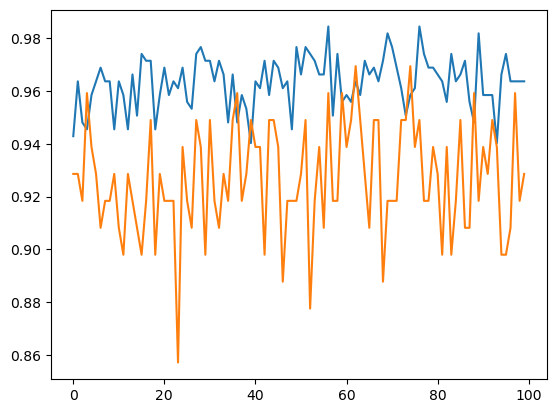

In [70]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

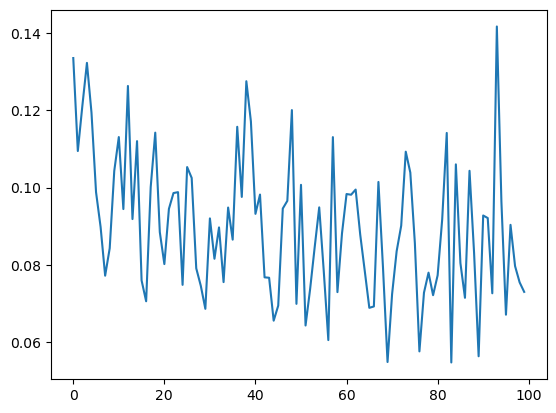

In [71]:
plt.plot(train_loss_hist)
plt.show()

In [85]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy() # clone() -> deepcopy, detach() -> 기울기 전파 x
    image = image.transpose(1,2,0)
    image = image * (np.array((0.5,0.5,0.5))) + np.array((0.5,0.5,0.5))
    image = image.clip(0,1)
    return image

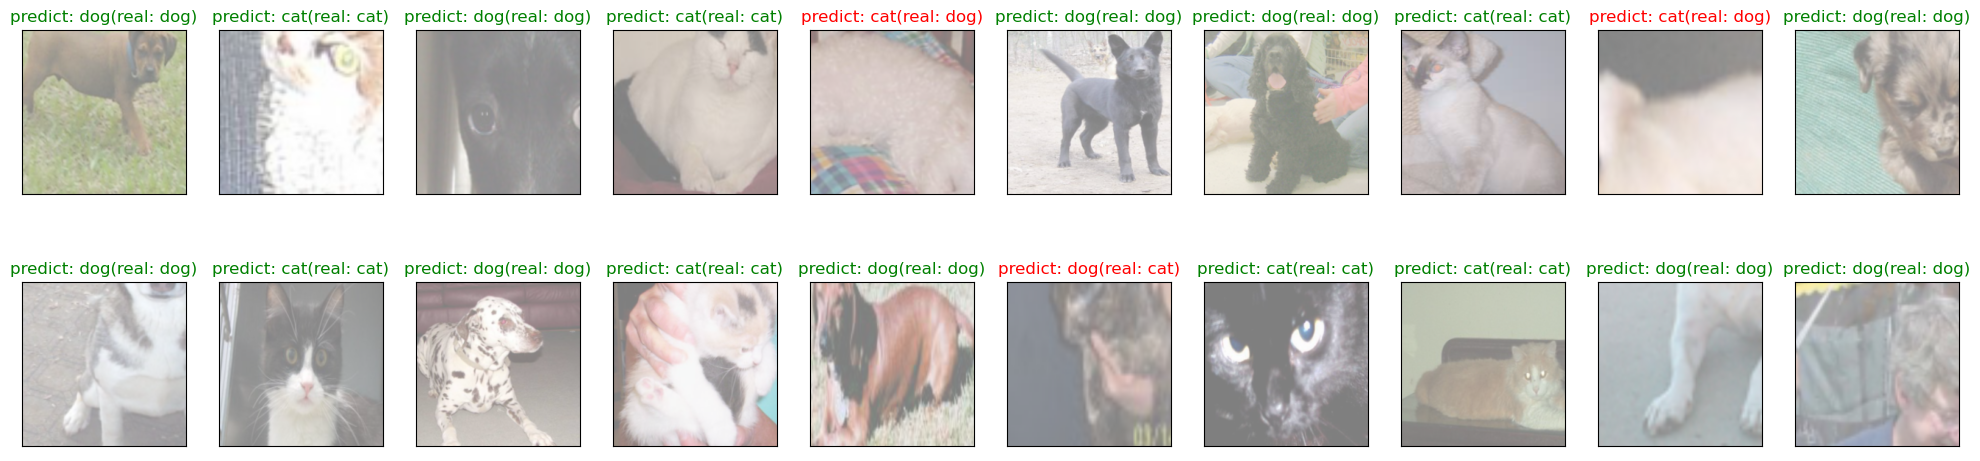

<Figure size 640x480 with 0 Axes>

In [90]:
classes = {0:'cat', 1:'dog'}

dataiter = iter(test_loader)
images, labels = next(dataiter)

images = images.to(device)
labels = labels.to(device)
output = resnet18(images)
_,preds = torch.max(output,1)

fig = plt.figure(figsize=(25,6))
for idx in np.arange(20):
    ax = fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])
    plt.imshow(im_convert(images[idx].cpu()))
    ax.set_title(classes[labels[idx].item()])
    ax.set_title("predict: {}(real: {})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx] == labels[idx] else 'red'))
plt.show()
plt.subplots_adjust(bottom=0.2, top=0.6,hspace=0)